In [45]:
'''
import pandas as pd
import cupy as cp
from cupy import diff

def calculate_skew_kurt(window):
    """Manual calculation of skewness and kurtosis using CuPy"""
    # Ensure float32 for GPU efficiency
    window = window.astype(cp.float32)
    
    # Calculate moments
    mean = cp.mean(window, axis=0)
    std = cp.std(window, axis=0, ddof=0)
    diffs = window - mean
    
    # Avoid division by zero
    std += cp.where(std == 0, 1e-8, 0)
    
    # Standardized values
    z = diffs / std
    
    # Calculate skewness and kurtosis
    skew = cp.mean(z**3, axis=0)
    kurt = cp.mean(z**4, axis=0) - 3  # Fisher's definition
    
    return skew, kurt

def extract_time_features(window, eeg_columns):
    """GPU-accelerated feature extraction with manual skew/kurtosis"""
    features = {}
    
    # Basic stats
    features.update({
        f'{col}_mean': val for col, val in zip(
            eeg_columns, cp.mean(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_std': val for col, val in zip(
            eeg_columns, cp.std(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_var': val for col, val in zip(
            eeg_columns, cp.var(window, axis=0).get().tolist())
    })
    
    # Signal characteristics
    features.update({
        f'{col}_max': val for col, val in zip(
            eeg_columns, cp.max(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_min': val for col, val in zip(
            eeg_columns, cp.min(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_ptp': val for col, val in zip(
            eeg_columns, cp.ptp(window, axis=0).get().tolist())
    })
    
    # Manual skew/kurt calculation
    skew_vals, kurt_vals = calculate_skew_kurt(window)
    features.update({
        f'{col}_skew': val for col, val in zip(eeg_columns, skew_vals.get().tolist())
    })
    features.update({
        f'{col}_kurt': val for col, val in zip(eeg_columns, kurt_vals.get().tolist())
    })
    
    # Zero-crossing
    sign_changes = diff((window >= 0).astype(int), axis=0)
    features.update({
        f'{col}_zcross': val for col, val in zip(
            eeg_columns, cp.sum(sign_changes != 0, axis=0).get().tolist())
    })
    
    # Energy features
    features.update({
        f'{col}_energy': val for col, val in zip(
            eeg_columns, cp.sum(window**2, axis=0).get().tolist())
    })
    features.update({
        f'{col}_rms': val for col, val in zip(
            eeg_columns, cp.sqrt(cp.mean(window**2, axis=0)).get().tolist())
    })
    
    return features

# Rest of the code remains the same as previous version...

def sliding_window_features(eeg_data, outcomes, eeg_columns, window_size, step_size):
    """GPU-accelerated sliding window feature extraction with target alignment."""
    features_list = []
    targets = []
    n_samples = eeg_data.shape[0]
    
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        window = eeg_data[start:end]
        outcome_window = outcomes[start:end]
        
        features = extract_time_features(window, eeg_columns)
        features_list.append(features)
        
        # Determine window target (modify based on your use case)
        targets.append(1 if cp.any(outcome_window) else 0)
    
    return features_list, targets

# Main processing
if __name__ == "__main__":
    # Load data with proper dtype specification
    data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
    eeg_columns = [col for col in data.columns if col != 'Outcome']
    
    # Convert to CuPy arrays with float32 precision
    eeg_data = cp.asarray(data[eeg_columns].values, dtype=cp.float32)
    outcomes = cp.asarray(data['Outcome'].values, dtype=cp.float32)
    
    # Window parameters
    fs = 256  # Sampling frequency
    window_size = fs * 1  # 1-second windows
    step_size = window_size // 2  # 50% overlap
    
    # Process data on GPU
    features, targets = sliding_window_features(
        eeg_data, outcomes, eeg_columns, window_size, step_size
    )
    
    # Convert to DataFrame and save
    features_df = pd.DataFrame(features)
    features_df['target'] = targets
    features_df.to_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv', index=False)
    print("Feature extraction complete. Features saved to 'eeg_features_gpu.csv'")

'''

Feature extraction complete. Features saved to 'eeg_features_gpu.csv'


In [14]:
import pandas as pd
import cupy as cp
from cupy import diff

def calculate_skew_kurt(window):
    """Manual calculation of skewness and kurtosis using CuPy"""
    # Ensure float32 for GPU efficiency
    window = window.astype(cp.float32)
    
    # Calculate moments
    mean = cp.mean(window, axis=0)
    std = cp.std(window, axis=0, ddof=1)
    diffs = window - mean
    
    # Avoid division by zero
    std += cp.where(std == 0, 1e-8, 0)
    
    # Standardized values
    z = diffs / std
    
    # Calculate skewness and kurtosis
    skew = cp.mean(z**3, axis=0)
    kurt = cp.mean(z**4, axis=0) - 3  # Fisher's definition
    
    return skew, kurt

def extract_time_features(window, eeg_columns):
    """GPU-accelerated feature extraction with manual skew/kurtosis,
    Hjorth parameters, and line length."""
    features = {}
    
    # Basic stats
    features.update({
        f'{col}_mean': val for col, val in zip(
            eeg_columns, cp.mean(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_std': val for col, val in zip(
            eeg_columns, cp.std(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_var': val for col, val in zip(
            eeg_columns, cp.var(window, axis=0).get().tolist())
    })
    
    # Signal characteristics
    features.update({
        f'{col}_max': val for col, val in zip(
            eeg_columns, cp.max(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_min': val for col, val in zip(
            eeg_columns, cp.min(window, axis=0).get().tolist())
    })
    features.update({
        f'{col}_ptp': val for col, val in zip(
            eeg_columns, cp.ptp(window, axis=0).get().tolist())
    })
    
    # Manual skew/kurt calculation
    skew_vals, kurt_vals = calculate_skew_kurt(window)
    features.update({
        f'{col}_skew': val for col, val in zip(eeg_columns, skew_vals.get().tolist())
    })
    features.update({
        f'{col}_kurt': val for col, val in zip(eeg_columns, kurt_vals.get().tolist())
    })
    
    # Zero-crossing
    sign_changes = diff(cp.sign(window), axis=0)
    features.update({
        f'{col}_zcross': val for col, val in zip(
            eeg_columns, cp.sum(sign_changes != 0, axis=0).get().tolist())
    })
    
    # Energy features
    features.update({
        f'{col}_energy': val for col, val in zip(
            eeg_columns, cp.sum(window**2, axis=0).get().tolist())
    })
    features.update({
        f'{col}_rms': val for col, val in zip(
            eeg_columns, cp.sqrt(cp.mean(window**2, axis=0)).get().tolist())
    })
    
    # Hjorth parameters
    # First derivative and second derivative along the time axis (axis=0)
    derivative = cp.diff(window, axis=0)
    second_derivative = cp.diff(derivative, axis=0)
    
    activity = cp.var(window, axis=0, ddof=1)
    mobility = cp.sqrt(cp.var(derivative, axis=0, ddof=1) / (activity + 1e-8))
    complexity = cp.sqrt(cp.var(second_derivative, axis=0, ddof=1) / (cp.var(derivative, axis=0, ddof=1) + 1e-8)) / (mobility + 1e-8)
    
    features.update({
        f'{col}_activity': val for col, val in zip(eeg_columns, activity.get().tolist())
    })
    features.update({
        f'{col}_mobility': val for col, val in zip(eeg_columns, mobility.get().tolist())
    })
    features.update({
        f'{col}_complexity': val for col, val in zip(eeg_columns, complexity.get().tolist())
    })
    
    # Line Length: Sum of absolute differences between consecutive points
    line_length = cp.sum(cp.abs(cp.diff(window, axis=0)), axis=0)
    features.update({
        f'{col}_line_length': val for col, val in zip(eeg_columns, line_length.get().tolist())
    })
    
    return features

def sliding_window_features(eeg_data, outcomes, eeg_columns, window_size, step_size):
    """GPU-accelerated sliding window feature extraction with target alignment."""
    features_list = []
    targets = []
    n_samples = eeg_data.shape[0]
    
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        window = eeg_data[start:end]
        outcome_window = outcomes[start:end]
        
        features = extract_time_features(window, eeg_columns)
        features_list.append(features)
        
        # Determine window target (modify based on your use case)
        targets.append(1 if cp.any(outcome_window) else 0)
    
    return features_list, targets

# Main processing
if __name__ == "__main__":
    # Load data with proper dtype specification
    data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
    eeg_columns = [col for col in data.columns if col != 'Outcome']
    
    # Convert to CuPy arrays with float32 precision
    eeg_data = cp.asarray(data[eeg_columns].values, dtype=cp.float32)
    outcomes = cp.asarray(data['Outcome'].values, dtype=cp.float32)
    
    # Window parameters
    fs = 256  # Sampling frequency
    window_size = fs * 1  # 1-second windows
    step_size = window_size // 2  # 50% overlap
    
    # Process data on GPU
    features, targets = sliding_window_features(
        eeg_data, outcomes, eeg_columns, window_size, step_size
    )
    
    # Convert to DataFrame and save
    features_df = pd.DataFrame(features)
    features_df['target'] = targets
    features_df.to_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timfeatures.csv', index=False)
    print("Feature extraction complete. Features saved")


Feature extraction complete. Features saved


In [5]:
df = pd.read_csv('D://MOOC.fi//Jupyter//EEG//Dataset/chbmit_preprocessed_data.csv')
df_f=pd.read_csv('D://MOOC.fi//Jupyter//EEG//Dataset//timfeatures.csv')

In [7]:
import numpy as np
print("\nMean and Standard Deviation for Data:")
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    print(f"{col}: Mean = {mean_val:.3f}, Std = {std_val:.3f}")


Mean and Standard Deviation for Data:
# FP1-F7: Mean = 0.000, Std = 0.000
C3-P3: Mean = 0.000, Std = 0.000
C4-P4: Mean = 0.000, Std = 0.000
CZ-PZ: Mean = 0.000, Std = 0.000
F3-C3: Mean = 0.000, Std = 0.000
F4-C4: Mean = 0.000, Std = 0.000
F7-T7: Mean = 0.000, Std = 0.000
F8-T8: Mean = 0.000, Std = 0.000
FP1-F3: Mean = 0.000, Std = 0.000
FP2-F4: Mean = 0.000, Std = 0.000
FP2-F8: Mean = 0.000, Std = 0.000
FT10-T8: Mean = 0.000, Std = 0.000
FT9-FT10: Mean = 0.000, Std = 0.000
FZ-CZ: Mean = 0.000, Std = 0.000
P3-O1: Mean = 0.000, Std = 0.000
P4-O2: Mean = 0.000, Std = 0.000
P7-O1: Mean = 0.000, Std = 0.000
P7-T7: Mean = 0.000, Std = 0.000
P8-O2: Mean = 0.000, Std = 0.000
T7-FT9: Mean = 0.000, Std = 0.000
T7-P7: Mean = 0.000, Std = 0.000
T8-P8-0: Mean = 0.000, Std = 0.000
T8-P8-1: Mean = 0.000, Std = 0.000
Outcome: Mean = 0.500, Std = 0.500


In [8]:
print("\nMean and Standard Deviation for Features:")
numeric_cols = df_f.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean_val = df_f[col].mean()
    std_val = df_f[col].std()
    print(f"{col}: Mean = {mean_val:.3f}, Std = {std_val:.3f}")


Mean and Standard Deviation for Features:
# FP1-F7_mean: Mean = 0.000, Std = 0.000
C3-P3_mean: Mean = 0.000, Std = 0.000
C4-P4_mean: Mean = 0.000, Std = 0.000
CZ-PZ_mean: Mean = 0.000, Std = 0.000
F3-C3_mean: Mean = 0.000, Std = 0.000
F4-C4_mean: Mean = 0.000, Std = 0.000
F7-T7_mean: Mean = 0.000, Std = 0.000
F8-T8_mean: Mean = 0.000, Std = 0.000
FP1-F3_mean: Mean = 0.000, Std = 0.000
FP2-F4_mean: Mean = 0.000, Std = 0.000
FP2-F8_mean: Mean = 0.000, Std = 0.000
FT10-T8_mean: Mean = 0.000, Std = 0.000
FT9-FT10_mean: Mean = 0.000, Std = 0.000
FZ-CZ_mean: Mean = 0.000, Std = 0.000
P3-O1_mean: Mean = 0.000, Std = 0.000
P4-O2_mean: Mean = 0.000, Std = 0.000
P7-O1_mean: Mean = 0.000, Std = 0.000
P7-T7_mean: Mean = 0.000, Std = 0.000
P8-O2_mean: Mean = 0.000, Std = 0.000
T7-FT9_mean: Mean = 0.000, Std = 0.000
T7-P7_mean: Mean = 0.000, Std = 0.000
T8-P8-0_mean: Mean = 0.000, Std = 0.000
T8-P8-1_mean: Mean = 0.000, Std = 0.000
# FP1-F7_std: Mean = 0.000, Std = 0.000
C3-P3_std: Mean = 0.000, St

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your extracted CSV
df = pd.read_csv("D://MOOC.fi//Jupyter//EEG//Dataset//timfeatures.csv")

# Separate features (all except the last column) and the target (last column)
features = df.iloc[:, :-1]
target = df.iloc[:, -1]

# Standardize only the feature columns
scaler = StandardScaler()
standardized_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Concatenate the standardized features with the target column
df_standardized = pd.concat([standardized_features, target], axis=1)

# Save the standardized DataFrame if needed
df_standardized.to_csv("D://MOOC.fi//Jupyter//EEG//Dataset//final.csv", index=False)

print("Standardization applied to:", features.columns.tolist())


Standardization applied to: ['# FP1-F7_mean', 'C3-P3_mean', 'C4-P4_mean', 'CZ-PZ_mean', 'F3-C3_mean', 'F4-C4_mean', 'F7-T7_mean', 'F8-T8_mean', 'FP1-F3_mean', 'FP2-F4_mean', 'FP2-F8_mean', 'FT10-T8_mean', 'FT9-FT10_mean', 'FZ-CZ_mean', 'P3-O1_mean', 'P4-O2_mean', 'P7-O1_mean', 'P7-T7_mean', 'P8-O2_mean', 'T7-FT9_mean', 'T7-P7_mean', 'T8-P8-0_mean', 'T8-P8-1_mean', '# FP1-F7_std', 'C3-P3_std', 'C4-P4_std', 'CZ-PZ_std', 'F3-C3_std', 'F4-C4_std', 'F7-T7_std', 'F8-T8_std', 'FP1-F3_std', 'FP2-F4_std', 'FP2-F8_std', 'FT10-T8_std', 'FT9-FT10_std', 'FZ-CZ_std', 'P3-O1_std', 'P4-O2_std', 'P7-O1_std', 'P7-T7_std', 'P8-O2_std', 'T7-FT9_std', 'T7-P7_std', 'T8-P8-0_std', 'T8-P8-1_std', '# FP1-F7_var', 'C3-P3_var', 'C4-P4_var', 'CZ-PZ_var', 'F3-C3_var', 'F4-C4_var', 'F7-T7_var', 'F8-T8_var', 'FP1-F3_var', 'FP2-F4_var', 'FP2-F8_var', 'FT10-T8_var', 'FT9-FT10_var', 'FZ-CZ_var', 'P3-O1_var', 'P4-O2_var', 'P7-O1_var', 'P7-T7_var', 'P8-O2_var', 'T7-FT9_var', 'T7-P7_var', 'T8-P8-0_var', 'T8-P8-1_var', '# 

In [16]:
df_f1=pd.read_csv("D://MOOC.fi//Jupyter//EEG//Dataset//final.csv")
print("\nMean and Standard Deviation for Features:")
numeric_cols = df_f1.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean_val = df_f1[col].mean()
    std_val = df_f1[col].std()
    print(f"{col}: Mean = {mean_val:.3f}, Std = {std_val:.3f}")


Mean and Standard Deviation for Features:
# FP1-F7_mean: Mean = 0.000, Std = 1.000
C3-P3_mean: Mean = 0.000, Std = 1.000
C4-P4_mean: Mean = -0.000, Std = 1.000
CZ-PZ_mean: Mean = -0.000, Std = 1.000
F3-C3_mean: Mean = 0.000, Std = 1.000
F4-C4_mean: Mean = -0.000, Std = 1.000
F7-T7_mean: Mean = -0.000, Std = 1.000
F8-T8_mean: Mean = -0.000, Std = 1.000
FP1-F3_mean: Mean = 0.000, Std = 1.000
FP2-F4_mean: Mean = 0.000, Std = 1.000
FP2-F8_mean: Mean = 0.000, Std = 1.000
FT10-T8_mean: Mean = 0.000, Std = 1.000
FT9-FT10_mean: Mean = -0.000, Std = 1.000
FZ-CZ_mean: Mean = 0.000, Std = 1.000
P3-O1_mean: Mean = -0.000, Std = 1.000
P4-O2_mean: Mean = -0.000, Std = 1.000
P7-O1_mean: Mean = -0.000, Std = 1.000
P7-T7_mean: Mean = 0.000, Std = 1.000
P8-O2_mean: Mean = -0.000, Std = 1.000
T7-FT9_mean: Mean = 0.000, Std = 1.000
T7-P7_mean: Mean = 0.000, Std = 1.000
T8-P8-0_mean: Mean = 0.000, Std = 1.000
T8-P8-1_mean: Mean = 0.000, Std = 1.000
# FP1-F7_std: Mean = -0.000, Std = 1.000
C3-P3_std: Mean 

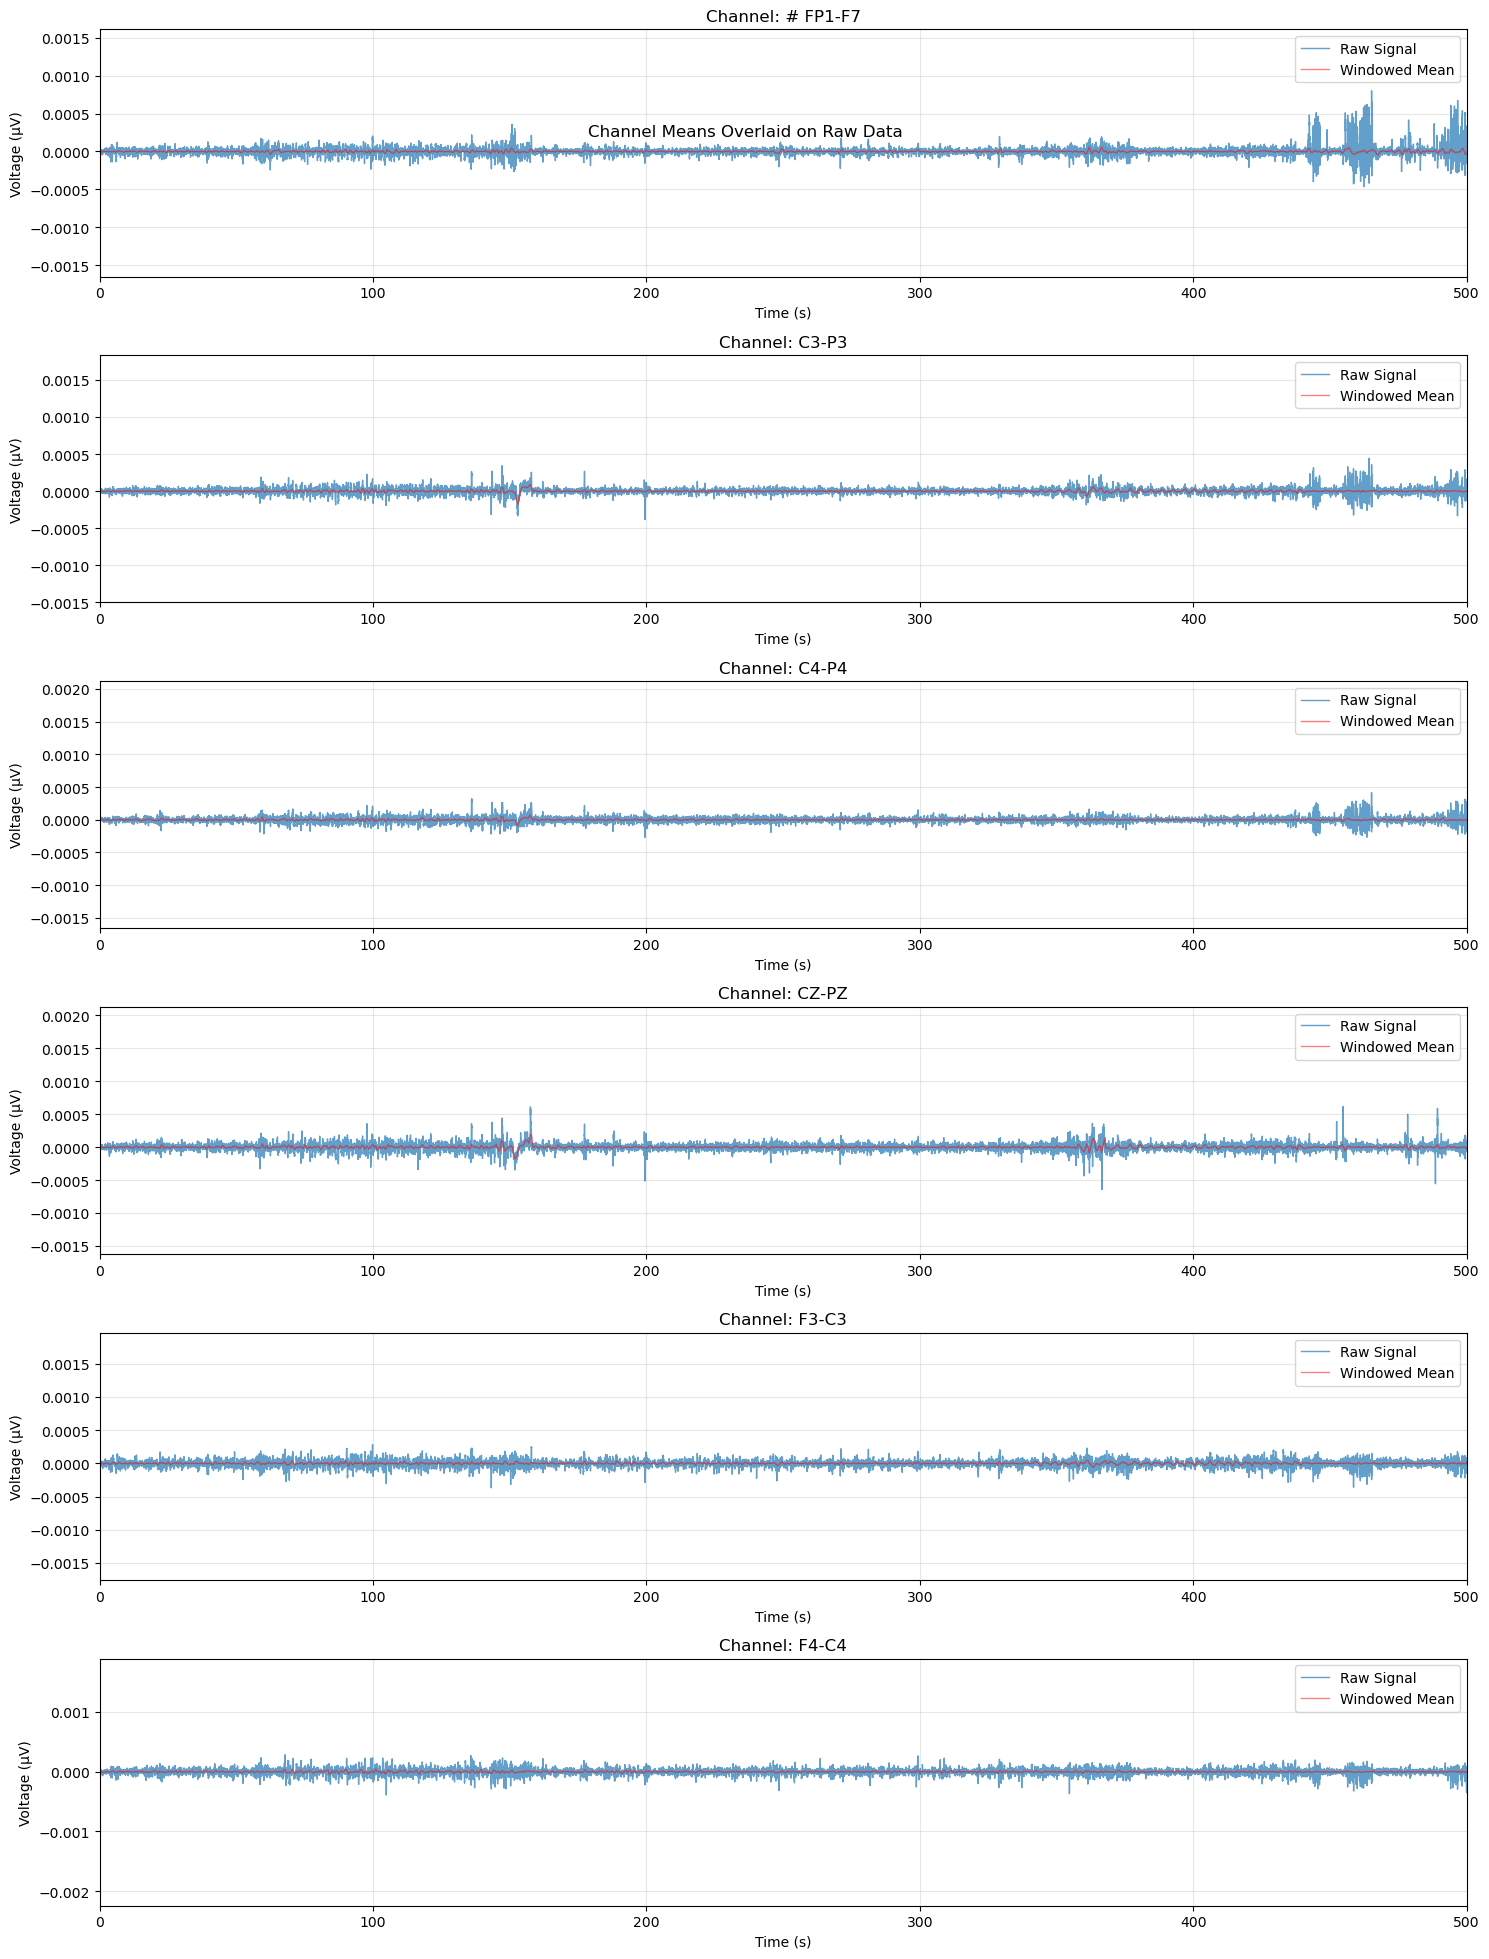

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
raw_data = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\chbmit_preprocessed_data.csv')
features_df = pd.read_csv('D:\\MOOC.fi\\Jupyter\\EEG\\Dataset\\timefeature_data.csv')

# Parameters
fs = 256  # Sampling frequency
window_size = 256  # 1-second window
step_size = 128  # 50% overlap
channels = [col for col in raw_data.columns if col != 'Outcome']

# Create time axes
raw_time = np.arange(len(raw_data)) / fs  # Original data time axis
feature_time = (np.arange(len(features_df)) * step_size + window_size//2) / fs  # Window centers

# Create figure
plt.figure(figsize=(15, 20))
plt.suptitle('Channel Means Overlaid on Raw Data', y=0.92)

# Plot each channel
for idx, channel in enumerate(channels[:6]):
    ax = plt.subplot(6, 1, idx+1)
    
    # Plot raw data
    ax.plot(raw_time, raw_data[channel], 
            alpha=0.7, 
            linewidth=1, 
            label='Raw Signal')
    
    # Plot windowed means from features
    ax.plot(feature_time, features_df[f'{channel}_mean'], 
            color='red',
            alpha=0.5,
            linewidth=1, 
            label='Windowed Mean')
    
    # Formatting
    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (μV)')
    ax.grid(True, alpha=0.3)
    ax.legend()
   
    ax.set_xlim(0, 500)

plt.tight_layout()
plt.savefig('channel_means_overlay.png', dpi=300)
plt.show()


In [43]:
# 2. Mean ± STD Band Visualization
window_stds = []
for start in range(0, len(fp1_f7_raw) - window_size + 1, step_size):
    window = fp1_f7_raw[start:start + window_size]
    window_stds.append(np.std(window))

window_stds = np.array(window_stds)

axs[1].fill_between(window_times, 
                   window_means - window_stds,
                   window_means + window_stds,
                   alpha=0.3, color='g', label='Mean ± STD')
axs[1].plot(window_times, window_means, color='r', linewidth=2)
axs[1].set_title('FP1-F7: Window Means with Standard Deviation Bands')
axs[1].set_ylabel('Voltage (μV)')
axs[1].legend()
axs[1].grid(True)

NameError: name 'fp1_f7_raw' is not defined